In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import *
from skimage.filters import *
from skimage.util import invert
from skimage.feature import canny, peak_local_max
from skimage.transform import rotate
from skimage.morphology import disk
import os
from scipy import ndimage as nd
from scipy.signal import find_peaks

In [11]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1, names=False):
    fnames = np.random.choice(os.listdir(images_path), k)
    images = tuple(map(get, fnames))
    if names: return images, fnames
    else: return images

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def ifft2d(image):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image)))

def peaks_filter(x:np.array, y:np.array, peaks:np.array, k:int=1):
    ypeaks = y[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

def pixel_scale(image:np.array):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = find_peaks(ymean), find_peaks(xmean)
    Py = peaks_filter(yfreqs, ymean, ypeaks, 2)
    Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
    
    return np.abs(xfreqs[Px][0]), np.abs(yfreqs[Py][0])

def pixel_scale_1d(sig1d:np.array):
    fft = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sig1d))))
    freqs = np.fft.ifftshift(np.fft.fftfreq(len(fft), 1))
    
    peaks, _ = find_peaks(fft)
    P = peaks_filter(freqs, fft, peaks, 2)
    
    return np.abs(freqs[P][0])

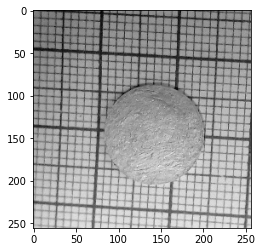

In [12]:
image = by_id(93)
#image = random_images()[0]
img = rgb2gray(image)
plt.imshow(img, cmap='gray')

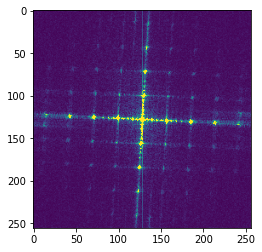

In [13]:
ifft = fft2d(img)
fft = np.abs(ifft)
freqs = np.stack(np.meshgrid(
    np.fft.ifftshift(np.fft.fftfreq(img.shape[0])),
    np.fft.ifftshift(np.fft.fftfreq(img.shape[1]))
), axis=2)
plt.imshow(fft, vmax=fft.max()*0.005)

In [14]:
Fx, Fy = pixel_scale(img)
Fx, Fy

(0.109375, 0.109375)

In [15]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='wrap')**2 +
                   nd.convolve(image, np.imag(kernel), mode='wrap')**2)

kernel_x = gabor_kernel(Fx, theta=0)
kernel_y = gabor_kernel(Fy, theta=np.pi/2)

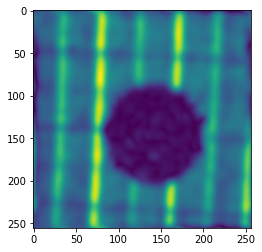

In [16]:
gabor_x = power(img, kernel_x)
plt.imshow(gabor_x)

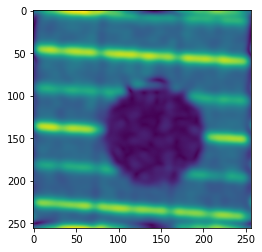

In [17]:
gabor_y = power(img, kernel_y)
plt.imshow(gabor_y)

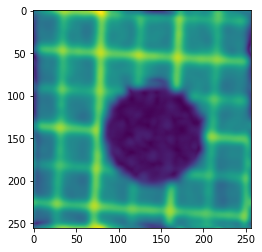

In [18]:
filtered = gabor_x + gabor_y
plt.imshow(filtered)

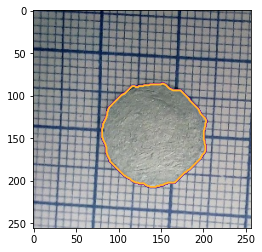

In [19]:
plt.imshow(image)
mask = filtered < threshold_minimum(filtered)
mask = nd.binary_opening(mask, iterations=5)
mask = nd.binary_dilation(mask, iterations=5)
plt.contour(mask, cmap='plasma')

18.jpg, 196.jpg, 37.jpg, 275.jpg, 117.jpg, 335.jpg, 206.jpg, 251.jpg, 335.jpg, 200.jpg, 68.jpg, 254.jpg, 178.jpg, 159.jpg, 100.jpg, 136.jpg, 340.jpg, 157.jpg, 188.jpg, 170.jpg, 92.jpg, 290.jpg, 300.jpg, 152.jpg, 144.jpg, 

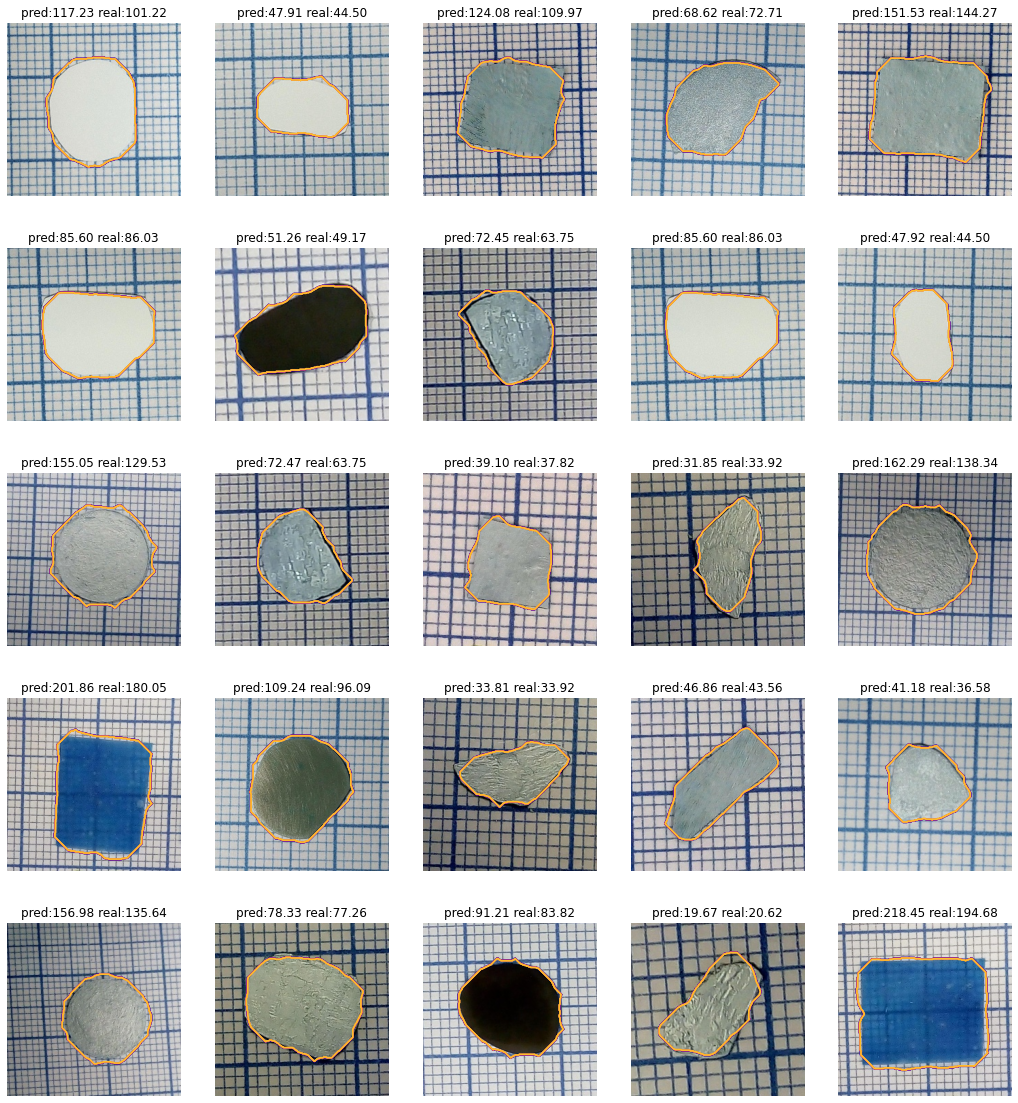

In [20]:
n = 5
r = 5
fig, axs = plt.subplots(r, n, figsize=(18, 4*r))
axs = axs.flatten()

for i, (image, name) in enumerate(zip(*random_images(r*n, names=True))):
    print(name, end=', ')
    
    img = rgb2gray(image)
    
    fx, fy = pixel_scale(img)
    kernel_x = gabor_kernel(fx, theta=0)
    kernel_y = gabor_kernel(fy, theta=np.pi/2)
    filtered = power(img, kernel_x) + power(img, kernel_y)
    mask = filtered < threshold_minimum(filtered)
    mask = nd.binary_opening(mask, iterations=10)
    mask = nd.binary_dilation(mask, iterations=10)
    
    axs[i].imshow(image)
    axs[i].contour(mask, cmap='plasma')
    
    axs[i].set_title(f'pred:{np.sum(mask)*fx*fy:.2f} real:{float(DS.loc[DS.filename == name].area):.2f}')
    axs[i].axis('off')
    
plt.show()

In [48]:
Fx*Fy*np.sum(mask), 

39.921875

In [218]:
X, Y = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, 2*np.pi, 100))
Zx = np.exp(2j*np.pi*X/fx)
Zy = np.exp(2j*np.pi*Y/fy)

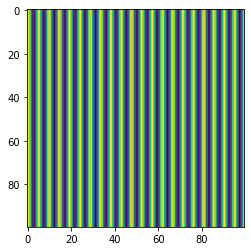

In [221]:
plt.imshow(np.real(Zx*np.exp(5j)))